TO-DO: there is still the same error maybe lets do processing on merged files 

In [7]:
import os
import shutil
import tempfile
from datetime import datetime
import calendar
from concurrent.futures import ThreadPoolExecutor
import requests
from requests.adapters import HTTPAdapter
from requests.packages.urllib3.util.retry import Retry
import xarray as xr

def set_up_session():
    """
    Set up a requests session with retry mechanism.

    Returns:
    - requests.Session: A requests session object.
    """
    session = requests.Session()
    retries = Retry(total=5, backoff_factor=1, status_forcelist=[502, 503, 504])
    session.mount('https://', HTTPAdapter(max_retries=retries))
    return session

def download_nc_files(session, year, month, base_directory, local_directory, start_day, end_day):
    """
    Download NetCDF files for a specified month and year.

    Parameters:
    - session (requests.Session): A requests session object.
    - year (int): The year for which to download files.
    - month (int): The month for which to download files.
    - base_directory (str): Base URL for the directory containing NetCDF files.
    - local_directory (str): Local directory to save downloaded files.
    - start_day (int): The starting day of the month to download files.
    - end_day (int): The ending day of the month to download files.

    Returns:
    - list: List of paths to the downloaded files.
    """
    month_url = f"{base_directory}/{year}{month:02d}"
    year_dir = f"{local_directory}/{year}"
    os.makedirs(year_dir, exist_ok=True)
    download_results = []
    for day in range(start_day, end_day + 1):
        date_string = f"{year}{month:02d}{day:02d}"
        file_url = f"{month_url}/oisst-avhrr-v02r01.{date_string}.nc"
        save_path = f"{year_dir}/oisst-avhrr-v02r01.{date_string}.nc"
        response = session.get(file_url)
        if response.status_code == 200:
            with open(save_path, 'wb') as file:
                file.write(response.content)
            download_results.append(save_path)
    return download_results

def process_files(file_paths):
    """
    Process downloaded NetCDF files.

    Parameters:
    - file_paths (list): List of paths to NetCDF files.
    """
    for file_path in file_paths:
        try:
            with tempfile.NamedTemporaryFile(delete=False) as tf:
                ds = xr.open_dataset(file_path)
                # Extract region of interest (Niño 3.4 region)
                sst_nino34 = ds.where(
                    (ds.lat < 5) & (ds.lat > -5) & (ds.lon > 190) & (ds.lon < 240), drop=True
                )
                sst_nino34.to_netcdf(tf.name)
                ds.close()
                sst_nino34.close()
            shutil.move(tf.name, file_path)
        except Exception as e:
            print(f"Error processing file {file_path}: {e}")

def download_and_merge_files_by_date_range(start_date, end_date, base_directory, local_directory):
    """
    Download and merge NetCDF files for a specified date range.

    Parameters:
    - start_date (str): Start date in the format 'YYYY-MM-DD'.
    - end_date (str): End date in the format 'YYYY-MM-DD'.
    - base_directory (str): Base URL for the directory containing NetCDF files.
    - local_directory (str): Local directory to save downloaded and merged files.
    """
    start_dt = datetime.strptime(start_date, '%Y-%m-%d')
    end_dt = datetime.strptime(end_date, '%Y-%m-%d')
    current_dt = start_dt
    session = set_up_session()

    # Iterate through each month within the specified date range
    while current_dt <= end_dt:
        year, month = current_dt.year, current_dt.month
        days_in_month = calendar.monthrange(year, month)[1]
        start_day = current_dt.day if current_dt.month == start_dt.month else 1
        end_day = days_in_month if end_dt.month != current_dt.month or end_dt.year != current_dt.year else end_dt.day

        # Download NetCDF files for the current month
        file_paths = download_nc_files(session, year, month, base_directory, local_directory, start_day, end_day)
        
        # Process downloaded files
        process_files(file_paths)
        
        # If it's the last month of the year or the end date is reached, merge files for the year
        if month == 12 or (year == end_dt.year and month == end_dt.month):
            year_dir = f"{local_directory}/{year}"
            yearly_files = [os.path.join(year_dir, f) for f in os.listdir(year_dir) if f.endswith('.nc')]
            yearly_merged_file = f"{local_directory}/merged_{year}.nc"
            # Merge files using xarray
            ds = xr.open_mfdataset(yearly_files, concat_dim='time', combine='nested', data_vars='minimal', coords='minimal', compat='override')
            ds.to_netcdf(yearly_merged_file)
            ds.close()
            # Clean up daily files for the year
            shutil.rmtree(year_dir)

        current_dt = datetime(year, month + 1, 1) if month != 12 else datetime(year + 1, 1, 1)

# Example to execute, uncomment if you want to use it
download_and_merge_files_by_date_range("2001-01-01", "2002-12-31",
                                      "https://www.ncei.noaa.gov/data/sea-surface-temperature-optimum-interpolation/v2.1/access/avhrr",
                                      "/workspace/soil-ml-modeling-pipeline/ml-modeling-pipeline/data/01_raw/sst")


In [8]:
import xarray as xr

ds = xr.open_dataset('/workspace/soil-ml-modeling-pipeline/ml-modeling-pipeline/data/01_raw/sst/merged_2001.nc')

In [9]:
ds

<xarray.Dataset> Size: 47MB
Dimensions:  (time: 365, zlev: 1, lat: 40, lon: 200)
Coordinates:
  * lat      (lat) float32 160B -4.875 -4.625 -4.375 ... 4.375 4.625 4.875
  * lon      (lon) float32 800B 190.1 190.4 190.6 190.9 ... 239.4 239.6 239.9
  * time     (time) datetime64[ns] 3kB 2001-01-01T12:00:00 ... 2001-12-31T12:...
  * zlev     (zlev) float32 4B 0.0
Data variables:
    anom     (time, zlev, lat, lon) float32 12MB ...
    err      (time, zlev, lat, lon) float32 12MB ...
    ice      (time, zlev, lat, lon) float32 12MB ...
    sst      (time, zlev, lat, lon) float32 12MB ...
Attributes: (12/37)
    title:                      NOAA/NCEI 1/4 Degree Daily Optimum Interpolat...
    source:                     ICOADS, NCEP_GTS, GSFC_ICE, NCEP_ICE, Pathfin...
    id:                         oisst-avhrr-v02r01.20010101.nc
    naming_authority:           gov.noaa.ncei
    summary:                    NOAAs 1/4-degree Daily Optimum Interpolation ...
    cdm_data_type:              Grid
    ...                         ...
    metadata_link:              https://doi.org/10.25921/RE9P-PT57
    ncei_template_version:      NCEI_NetCDF_Grid_Template_v2.0
    comment:                    Data was converted from NetCDF-3 to NetCDF-4 ...
    sensor:                     Thermometer, AVHRR
    Conventions:                CF-1.6, ACDD-1.3
    references:                 Reynolds, et al.(2007) Daily High-Resolution-...

https://foundations.projectpythia.org/core/xarray/enso-xarray.html

In [16]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import xarray as xr

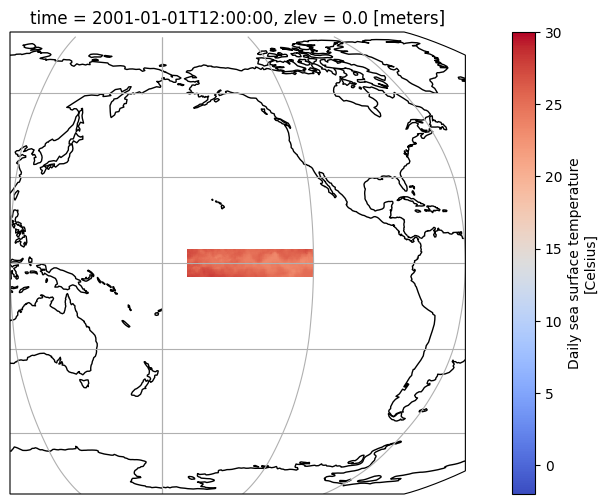

In [15]:
fig = plt.figure(figsize=(12, 6))
ax = plt.axes(projection=ccrs.Robinson(central_longitude=180))
ax.coastlines()
ax.gridlines()
ds.sst.isel(time=0).plot(
    ax=ax, transform=ccrs.PlateCarree(), vmin=-2, vmax=30, cmap='coolwarm'
)
ax.set_extent((120, 300, 10, -10))

In [23]:
import matplotlib.colors as mcolors

def create_custom_colormap():
    """
    Create a custom colormap similar to the NOAA OISST V2.1 color scale with adjusted blue dominance near zero.
    
    Returns:
    LinearSegmentedColormap: Custom colormap.
    """
    colors = ["#800080", "#0000FF", "#00FFFF", "#00FF00", "#FFFF00", "#FFA500", "#FF0000"]
    # Adjusted nodes to emphasize blue near zero and delay transition to warmer colors
    nodes = [0.0, 0.2, 0.4, 0.6, 0.7, 0.8, 1.0]  # Delay transition to warmer colors
    cmap = mcolors.LinearSegmentedColormap.from_list("custom_oisst_adjusted", list(zip(nodes, colors)))
    return cmap

def plot_sst_with_cartopy(ds, var_name='sst', time_index=0):
    """
    Plot Sea Surface Temperature (SST) using an adjusted custom colormap and Cartopy for map projection.

    Args:
    ds (xarray.Dataset): The dataset containing SST data.
    var_name (str): The variable name to plot, default is 'sst'.
    time_index (int): Time index to plot, default is 0.

    Returns:
    matplotlib.figure.Figure: The figure object containing the plot.
    """
    # Create the adjusted custom colormap
    cmap = create_custom_colormap()

    # Select the data at the specific time index
    data = ds[var_name].isel(time=time_index)

    # Create a figure with an appropriate size
    plt.figure(figsize=(12, 7))

    # Set up the map projection and plot the data
    ax = plt.axes(projection=ccrs.Robinson())
    ax.coastlines()
    ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)

    # Plotting the data
    data.plot(ax=ax, transform=ccrs.PlateCarree(), cmap=cmap, cbar_kwargs={'shrink': 0.5})

    # Set plot title and display
    plt.title(f'{var_name.upper()} (Time index: {time_index})', fontsize=14)
    plt.show()

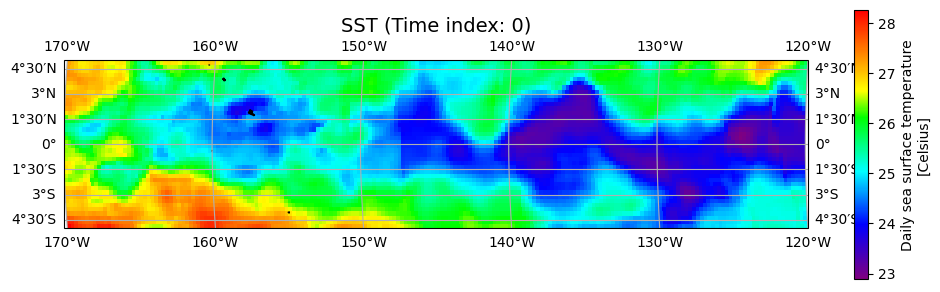

In [24]:
plot_sst_with_cartopy(ds)

In [19]:
import xarray as xr
import numpy as np

def calculate_cell_area(lat, lon):
    """
    Calculate the approximate cell area for each grid cell in square meters.
    
    Parameters:
        lat (np.ndarray): Latitude array which can be 1D or 2D.
        lon (np.ndarray): Longitude array which can be 1D or 2D.
        
    Returns:
        np.ndarray: An array of cell areas in square meters with the same dimensions as the input arrays.
    """
    R = 6371000  # Earth radius in meters
    if lat.ndim == 1:
        lat_rad = np.radians(lat)
        d_lat = np.radians(np.gradient(lat))
        d_lon = np.radians(np.gradient(lon))
        lat_rad = lat_rad[:, np.newaxis]
        d_lat = d_lat[:, np.newaxis]
        d_lon = d_lon[np.newaxis, :]
    else:
        lat_rad = np.radians(lat)
        d_lat = np.radians(np.gradient(lat, axis=0))
        d_lon = np.radians(np.gradient(lon, axis=1))

    area = (R**2) * np.abs(d_lat * d_lon * np.cos(lat_rad))
    return area

def add_area_to_dataset(ds, lat_name='lat', lon_name='lon'):
    """
    Add cell area to an xarray dataset as a new data variable `areacello`.
    
    Parameters:
        ds (xr.Dataset): Input dataset containing latitude and longitude coordinates.
        lat_name (str): Name of the latitude coordinate in the dataset.
        lon_name (str): Name of the longitude coordinate in the dataset.
    
    Returns:
        xr.Dataset: The dataset with an added `areacello` data variable.
    """
    lat = ds[lat_name].data
    lon = ds[lon_name].data
    areacello = calculate_cell_area(lat, lon)

    if areacello.ndim == 1:
        areacello = areacello[:, np.newaxis]
        areacello = np.tile(areacello, (1, len(lon)))

    ds['areacello'] = (('lat', 'lon'), areacello)
    ds['areacello'].attrs['units'] = 'm^2'
    ds['areacello'].attrs['long_name'] = 'Area of grid cells'

    return ds

# Example usage would be:
ds = add_area_to_dataset(ds)
  


In [25]:
ds

<xarray.Dataset> Size: 47MB
Dimensions:    (time: 365, zlev: 1, lat: 40, lon: 200)
Coordinates:
  * lat        (lat) float32 160B -4.875 -4.625 -4.375 ... 4.375 4.625 4.875
  * lon        (lon) float32 800B 190.1 190.4 190.6 190.9 ... 239.4 239.6 239.9
  * time       (time) datetime64[ns] 3kB 2001-01-01T12:00:00 ... 2001-12-31T1...
  * zlev       (zlev) float32 4B 0.0
Data variables:
    anom       (time, zlev, lat, lon) float32 12MB ...
    err        (time, zlev, lat, lon) float32 12MB ...
    ice        (time, zlev, lat, lon) float32 12MB ...
    sst        (time, zlev, lat, lon) float32 12MB ...
    areacello  (lat, lon) float64 64kB 7.7e+08 7.7e+08 ... 7.7e+08 7.7e+08
Attributes: (12/37)
    title:                      NOAA/NCEI 1/4 Degree Daily Optimum Interpolat...
    source:                     ICOADS, NCEP_GTS, GSFC_ICE, NCEP_ICE, Pathfin...
    id:                         oisst-avhrr-v02r01.20010101.nc
    naming_authority:           gov.noaa.ncei
    summary:                    NOAAs 1/4-degree Daily Optimum Interpolation ...
    cdm_data_type:              Grid
    ...                         ...
    metadata_link:              https://doi.org/10.25921/RE9P-PT57
    ncei_template_version:      NCEI_NetCDF_Grid_Template_v2.0
    comment:                    Data was converted from NetCDF-3 to NetCDF-4 ...
    sensor:                     Thermometer, AVHRR
    Conventions:                CF-1.6, ACDD-1.3
    references:                 Reynolds, et al.(2007) Daily High-Resolution-...

In [26]:
gb = ds.sst.groupby('time.month')
ds_anom = gb - gb.mean(dim='time')
index_nino34 = ds_anom.weighted(ds.areacello).mean(dim=['lat', 'lon'])

In [27]:
index_nino34

<xarray.DataArray 'sst' (time: 365, zlev: 1)> Size: 3kB
array([[-4.95899739e-01],
       [-2.61986766e-01],
       [-1.76032586e-01],
       [-2.33215304e-01],
       [-2.29485225e-01],
       [-2.25539955e-01],
       [-1.83017935e-01],
       [-2.16896997e-01],
       [-2.29289579e-01],
       [-2.61958075e-01],
       [-2.73251050e-01],
       [-1.65513359e-01],
       [-1.02782254e-01],
       [-1.75509947e-02],
       [ 6.64097677e-02],
       [ 1.61379761e-01],
       [ 2.33513763e-01],
       [ 1.80400971e-01],
       [ 1.46273532e-01],
       [ 1.59544245e-01],
...
       [-1.16247276e-01],
       [-1.76162805e-01],
       [-1.66836524e-01],
       [-1.99774283e-01],
       [-1.46714129e-01],
       [-1.00888075e-01],
       [-6.93375316e-02],
       [ 8.28379629e-02],
       [ 1.90093793e-01],
       [ 1.74367402e-01],
       [ 1.20146549e-01],
       [ 1.00462075e-01],
       [ 1.45780178e-01],
       [ 1.36765955e-01],
       [ 1.38049378e-02],
       [-1.78719979e-01],
       [-1.38633416e-01],
       [-3.88151341e-02],
       [ 6.14467939e-03],
       [ 8.85986938e-02]])
Coordinates:
  * time     (time) datetime64[ns] 3kB 2001-01-01T12:00:00 ... 2001-12-31T12:...
  * zlev     (zlev) float32 4B 0.0
    month    (time) int64 3kB 1 1 1 1 1 1 1 1 1 1 ... 12 12 12 12 12 12 12 12 12

In [28]:
index_nino34_rolling_mean = index_nino34.rolling(time=5, center=True).mean()

Text(0.5, 1.0, 'SST anomaly over the Niño 3.4 region')

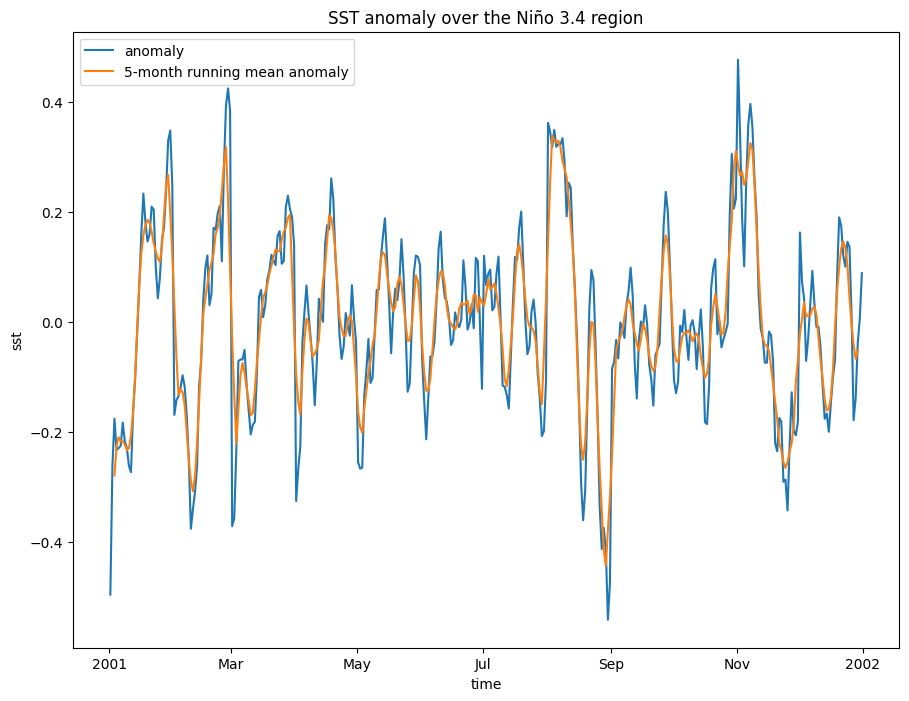

In [29]:
index_nino34.plot(size=8)
index_nino34_rolling_mean.plot()
plt.legend(['anomaly', '5-month running mean anomaly'])
plt.title('SST anomaly over the Niño 3.4 region')